Attempting to load file from: d:\Projects\aki_prediction_project\data\processed\preop_train_cleaned.csv
Successfully loaded file. Selected Test Case ID: 4331

Loading waveform data for case 4331...
Downsampling waveform...
Extracting first 10-second segment...
Processing segment to generate spectrogram...

Generating plots for verification...


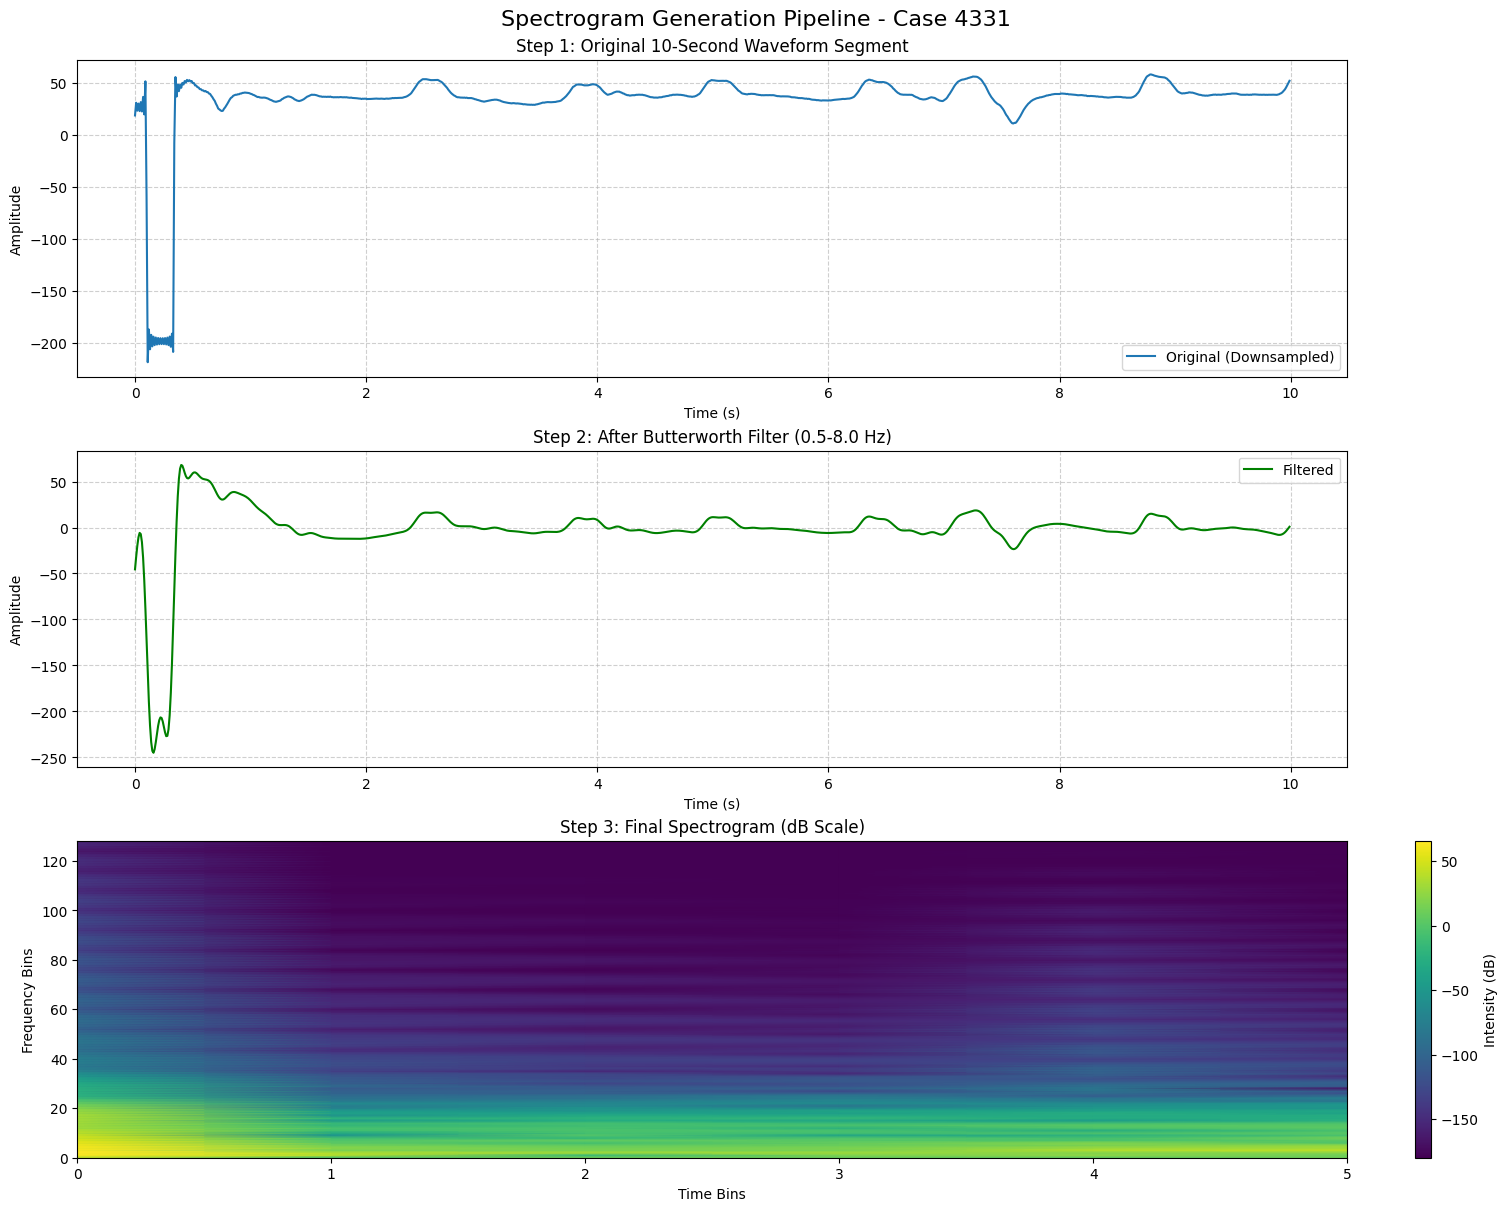


Test successful. Spectrogram generated with shape: (129, 6)


In [7]:
# --- Imports ---
# Import all necessary libraries for processing and plotting.
import pandas as pd
import numpy as np
import vitaldb
from scipy import signal
import matplotlib.pyplot as plt
import os

# --- Configuration & Function (Copied from the main script) ---
# We use the exact same configuration and processing function to ensure
# this test perfectly reflects how the main script will behave.

# 1. Waveform & Processing Parameters
TRACK_NAME = 'SNUADC/PLETH'
ORIGINAL_SR = 500
DOWNSAMPLE_SR = 100
SEGMENT_SECONDS = 10
SEGMENT_SAMPLES = DOWNSAMPLE_SR * SEGMENT_SECONDS

# 2. Spectrogram Generation Parameters
SPECTROGRAM_WINDOW_SAMPLES = 256
SPECTROGRAM_OVERLAP_SAMPLES = 128
SPECTROGRAM_FFT_POINTS = 256

# 3. Signal Cleaning Parameters
FILTER_ORDER = 4
LOW_HZ = 0.5
HIGH_HZ = 8.0

def process_segment(segment, sr):
    """
    Processes a single 10-second waveform segment by cleaning it and
    converting it into a spectrogram.
    """
    if np.nanvar(segment) < 1e-6:
        print("Segment rejected due to low variance (flat-line).")
        return None, None

    # Apply Butterworth bandpass filter
    try:
        b, a = signal.butter(FILTER_ORDER, [LOW_HZ, HIGH_HZ], btype='band', fs=sr)
        filtered_segment = signal.filtfilt(b, a, segment)
    except (ValueError, np.linalg.LinAlgError) as e:
        print(f"Error during filtering: {e}")
        return None, None

    # Generate Spectrogram
    f, t, Sxx = signal.spectrogram(filtered_segment,
                                   fs=sr,
                                   nperseg=SPECTROGRAM_WINDOW_SAMPLES,
                                   noverlap=SPECTROGRAM_OVERLAP_SAMPLES,
                                   nfft=SPECTROGRAM_FFT_POINTS)

    Sxx_db = 20 * np.log10(Sxx + 1e-9)
    return filtered_segment, Sxx_db

# --- Single Case Test Execution ---

# 1. Select a Test Case
# We'll load the training data to ensure we pick a valid caseid.
# The path is corrected to '../' to go up one directory from 'notebooks/'.
FILE_PATH = '../data/processed/preop_train_cleaned.csv'
try:
    print(f"Attempting to load file from: {os.path.abspath(FILE_PATH)}")
    train_df = pd.read_csv(FILE_PATH)
    TEST_CASEID = train_df['caseid'].iloc[0] # Use the first case from the training set
    print(f"Successfully loaded file. Selected Test Case ID: {TEST_CASEID}")
except (FileNotFoundError, IndexError):
    print(f"Warning: Could not load {FILE_PATH}. Defaulting to caseid 1.")
    TEST_CASEID = 1

# 2. Load and Prepare Data
print(f"\nLoading waveform data for case {TEST_CASEID}...")
raw_waveform = vitaldb.load_case(TEST_CASEID, [TRACK_NAME], 1 / ORIGINAL_SR)

# Remove any NaN values which can interfere with processing
raw_waveform = raw_waveform[~np.isnan(raw_waveform)]

print("Downsampling waveform...")
resample_len = int(len(raw_waveform) * DOWNSAMPLE_SR / ORIGINAL_SR)
resampled_waveform = signal.resample(raw_waveform, resample_len).flatten()

# 3. Extract a single segment
# We'll take the first full segment from the resampled waveform.
print(f"Extracting first {SEGMENT_SECONDS}-second segment...")
test_segment = resampled_waveform[:SEGMENT_SAMPLES]

# 4. Process the Segment
print("Processing segment to generate spectrogram...")
filtered_segment, spectrogram = process_segment(test_segment, DOWNSAMPLE_SR)


# --- Visualization ---
# This is the key benefit of the notebook: visually inspect each step.
if spectrogram is not None:
    print("\nGenerating plots for verification...")
    
    # Create a time axis for the plot
    time_axis = np.arange(test_segment.size) / DOWNSAMPLE_SR
    
    plt.style.use('default')
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), constrained_layout=True)
    fig.suptitle(f'Spectrogram Generation Pipeline - Case {TEST_CASEID}', fontsize=16)

    # Plot 1: Original Raw Segment
    axes[0].plot(time_axis, test_segment, label='Original (Downsampled)')
    axes[0].set_title('Step 1: Original 10-Second Waveform Segment')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].legend()

    # Plot 2: Filtered Segment
    axes[1].plot(time_axis, filtered_segment, label='Filtered', color='green')
    axes[1].set_title(f'Step 2: After Butterworth Filter ({LOW_HZ}-{HIGH_HZ} Hz)')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].legend()

    # Plot 3: Final Spectrogram
    im = axes[2].pcolormesh(spectrogram, shading='gouraud', cmap='viridis')
    axes[2].set_title('Step 3: Final Spectrogram (dB Scale)')
    axes[2].set_ylabel('Frequency Bins')
    axes[2].set_xlabel('Time Bins')
    fig.colorbar(im, ax=axes[2], label='Intensity (dB)')

    plt.show()
    
    print(f"\nTest successful. Spectrogram generated with shape: {spectrogram.shape}")
else:
    print("\nTest failed. No spectrogram was generated. Please check the segment data.")


--- .npy File Validation Test ---
Found 3415867 spectrogram files.
Attempting to load random file: ../data/processed/spectrograms/pleth/5144_1527.npy

--- Validation Succeeded ---
File: '5144_1527.npy' loaded successfully.
  - Array Shape: (129, 6)
  - Data Type: float32
  - Min Value: nan
  - Max Value: nan


C:\Users\steal\AppData\Local\Temp\ipykernel_34656\2671548100.py:33: RuntimeWarning: All-NaN slice encountered
  print(f"  - Min Value: {np.nanmin(spectrogram):.2f}") # Use nanmin to ignore potential NaN values
C:\Users\steal\AppData\Local\Temp\ipykernel_34656\2671548100.py:34: RuntimeWarning: All-NaN slice encountered
  print(f"  - Max Value: {np.nanmax(spectrogram):.2f}") # Use nanmax to ignore potential NaN values
c:\Users\steal\anaconda3\envs\aki_prediction_project\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


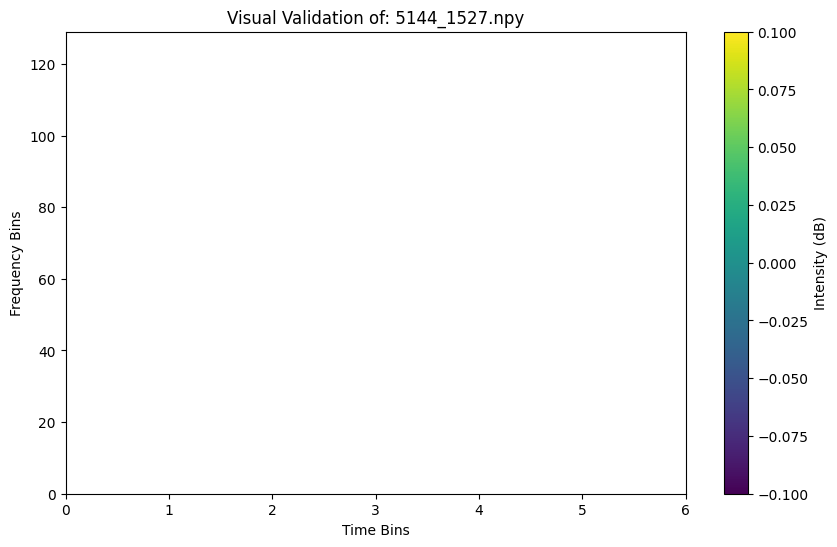

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Configuration ---
# Define the path to the directory containing the spectrograms.
# Note the '../' to navigate up from the 'notebooks/' directory.
SPECTROGRAM_DIR = '../data/processed/spectrograms/pleth/'

print("--- .npy File Validation Test ---")

# --- Main Test Logic ---
try:
    # 1. Get a list of all .npy files
    all_files = [f for f in os.listdir(SPECTROGRAM_DIR) if f.endswith('.npy')]
    if not all_files:
        raise FileNotFoundError("No .npy files found in the directory.")
        
    print(f"Found {len(all_files)} spectrogram files.")

    # 2. Select a random file to test
    random_file = random.choice(all_files)
    file_path = os.path.join(SPECTROGRAM_DIR, random_file)
    print(f"Attempting to load random file: {file_path}")

    # 3. Load the file using numpy
    spectrogram = np.load(file_path)
    print("\n--- Validation Succeeded ---")
    print(f"File: '{random_file}' loaded successfully.")
    print(f"  - Array Shape: {spectrogram.shape}")
    print(f"  - Data Type: {spectrogram.dtype}")
    print(f"  - Min Value: {np.nanmin(spectrogram):.2f}") # Use nanmin to ignore potential NaN values
    print(f"  - Max Value: {np.nanmax(spectrogram):.2f}") # Use nanmax to ignore potential NaN values

    # 4. Plot the loaded data for visual confirmation
    plt.figure(figsize=(10, 6))
    
    # Dynamically set the color range based on the data's distribution
    # This prevents the plot from appearing blank.
    # We ignore NaNs when calculating percentiles.
    vmin = np.nanpercentile(spectrogram, 5)
    vmax = np.nanpercentile(spectrogram, 95)
    
    plt.pcolormesh(spectrogram, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"Visual Validation of: {random_file}")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Time Bins")
    plt.colorbar(label="Intensity (dB)")
    plt.show()

except FileNotFoundError as e:
    print(f"\nERROR: Could not find the spectrogram directory or files.")
    print(f"  - Details: {e}")
    print(f"  - Please ensure Phase 5 (data generation) has run and created files in: {os.path.abspath(SPECTROGRAM_DIR)}")
except Exception as e:
    print(f"\nAn unexpected ERROR occurred while loading or plotting the .npy file: {e}")

